In [2]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import SMOTE
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, f1_score, precision_score, recall_score, roc_auc_score, roc_curve
import matplotlib.pyplot as plt


In [3]:
df_train = pd.read_csv("data/train.csv")
df_test = pd.read_csv("data/test.csv")

df_train.head()

,EmployeeNo,Division,Qualification,Gender,Channel_of_Recruitment,Trainings_Attended,Year_of_birth,Last_performance_score,Year_of_recruitment,Targets_met,Previous_Award,Training_score_average,State_Of_Origin,Foreign_schooled,Marital_Status,Past_Disciplinary_Action,Previous_IntraDepartmental_Movement,No_of_previous_employers,Promoted_or_Not
0,YAK/S/00001,Commercial Sales and Marketing,"MSc, MBA and PhD",Female,Direct Internal process,2,1986,12.5,2011,1,0,41,ANAMBRA,No,Married,No,No,0,0
1,YAK/S/00002,Customer Support and Field Operations,First Degree or HND,Male,Agency and others,2,1991,12.5,2015,0,0,52,ANAMBRA,Yes,Married,No,No,0,0
2,YAK/S/00003,Commercial Sales and Marketing,First Degree or HND,Male,Direct Internal process,2,1987,7.5,2012,0,0,42,KATSINA,Yes,Married,No,No,0,0
3,YAK/S/00004,Commercial Sales and Marketing,First Degree or HND,Male,Agency and others,3,1982,2.5,2009,0,0,42,NIGER,Yes,Single,No,No,1,0
4,YAK/S/00006,Information and Strategy,First Degree or HND,Male,Direct Internal process,3,1990,7.5,2012,0,0,77,AKWA IBOM,Yes,Married,No,No,1,0


In [185]:
df_test.columns

Index(['EmployeeNo', 'Trainings_Attended', 'Year_of_birth',
       'Last_performance_score', 'Year_of_recruitment', 'Targets_met',
       'Previous_Award', 'Training_score_average', 'Division_encoded',
       'Qualification_encoded', 'Gender_encoded',
       'Channel_of_Recruitment_encoded', 'State_Of_Origin_encoded',
       'Foreign_schooled_encoded', 'Marital_Status_encoded',
       'Past_Disciplinary_Action_encoded',
       'Previous_IntraDepartmental_Movement_encoded',
       'No_of_previous_employers_encoded'],
      dtype='object')

In [136]:
df_train['Promoted_or_Not'].value_counts()

Promoted_or_Not
0    35071
1     3241
Name: count, dtype: int64

In [137]:
count = df_train.groupby(['Qualification', 'Promoted_or_Not']).size().unstack(fill_value=0)

count

Promoted_or_Not,0,1
Qualification,,
First Degree or HND,23483,2095
"MSc, MBA and PhD",9457,1012
Non-University Education,534,52


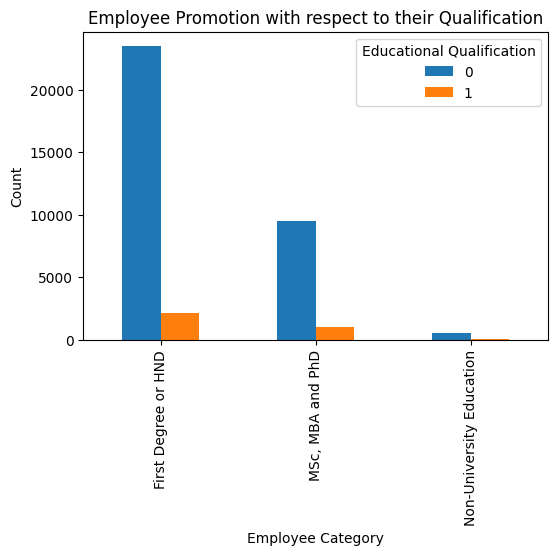

In [45]:
fig, ax = plt.subplots(figsize = (6, 4))

count.plot(
    kind="bar",
    stacked=False,
    ax=ax
)

plt.title("Employee Promotion with respect to their Qualification")
plt.xlabel("Employee Category")
plt.ylabel("Count")
plt.legend(title = "Educational Qualification")
plt.show()

In [46]:
count = df_train.groupby(['Division', 'Promoted_or_Not']).size().unstack(fill_value=0)

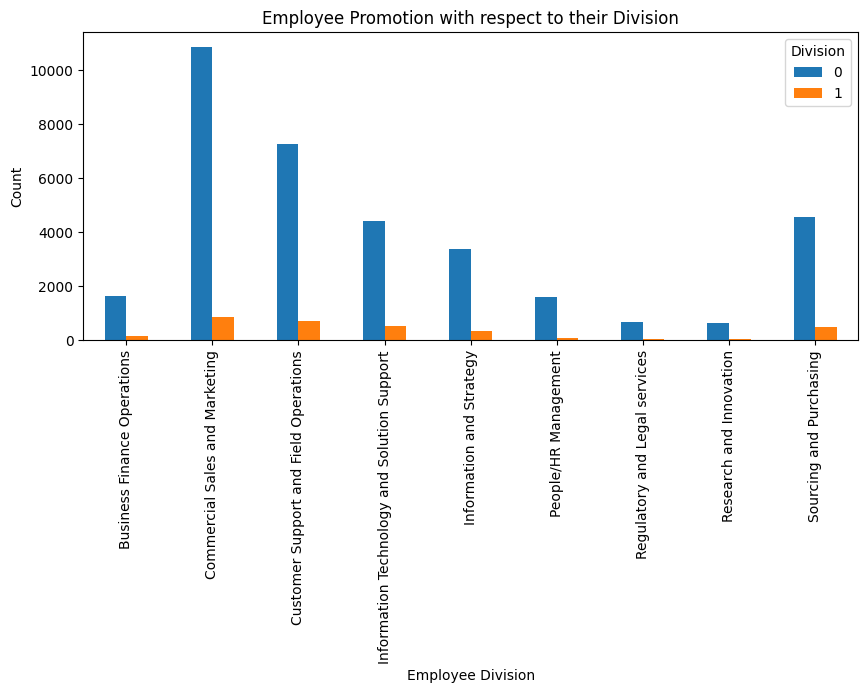

In [48]:
fig, ax = plt.subplots(figsize = (10, 4))

count.plot(
    kind="bar",
    stacked=False,
    ax=ax
)

plt.title("Employee Promotion with respect to their Division")
plt.xlabel("Employee Division")
plt.ylabel("Count")
plt.legend(title = "Division")
plt.show()

In [4]:
# categorical columns

cat_col = [col for col in df_train.columns if df_train[col].dtype == "O" and col != "EmployeeNo"]

In [139]:
cat_col

['Division',
 'Qualification',
 'Gender',
 'Channel_of_Recruitment',
 'State_Of_Origin',
 'Foreign_schooled',
 'Marital_Status',
 'Past_Disciplinary_Action',
 'Previous_IntraDepartmental_Movement',
 'No_of_previous_employers']

In [140]:
for col in df_train[cat_col]:
    if col != "EmployeeNo":
        print(f"Number of unique categories: {df_train[col].nunique()}")
        print(f"{col}: {df_train[col].unique()}")
        print("\n")

Number of unique categories: 9
Division: ['Commercial Sales and Marketing' 'Customer Support and Field Operations'
 'Information and Strategy' 'Information Technology and Solution Support'
 'Sourcing and Purchasing' 'Business Finance Operations'
 'People/HR Management' 'Research and Innovation'
 'Regulatory and Legal services']


Number of unique categories: 3
Qualification: ['MSc, MBA and PhD' 'First Degree or HND' nan 'Non-University Education']


Number of unique categories: 2
Gender: ['Female' 'Male']


Number of unique categories: 3
Channel_of_Recruitment: ['Direct Internal process' 'Agency and others'
 'Referral and Special candidates']


Number of unique categories: 37
State_Of_Origin: ['ANAMBRA' 'KATSINA' 'NIGER' 'AKWA IBOM' 'ENUGU' 'OYO' 'LAGOS' 'ONDO'
 'KWARA' 'EDO' 'BAUCHI' 'TARABA' 'RIVERS' 'KADUNA' 'PLATEAU' 'EKITI'
 'BORNO' 'IMO' 'CROSS RIVER' 'KANO' 'FCT' 'OGUN' 'GOMBE' 'DELTA' 'BENUE'
 'ZAMFARA' 'OSUN' 'ABIA' 'KEBBI' 'ADAMAWA' 'NASSARAWA' 'SOKOTO' 'KOGI'
 'JIGAWA' 'BAYE

In [5]:
def encode_columns(train_df, test_df, columns):
    encoders = {}
    for column in columns:
        encoder = LabelEncoder()
        train_df[column + '_encoded'] = encoder.fit_transform(train_df[column])
        test_df[column + '_encoded'] = test_df[column].apply(lambda x: encoder.transform([x])[0] if x in encoder.classes_ else -1)
        encoders[column] = encoder
    return train_df, test_df, encoders

In [6]:
# col_to_encode = ['State_Of_Origin', 'Division', 'Channel_of_Recruitment']


df_train, test_df_df_testencoded, encoders = encode_columns(df_train, df_test, cat_col)



In [7]:
df_train.drop(columns=cat_col, axis=1, inplace=True)
df_test.drop(columns=cat_col, axis=1, inplace=True)

In [39]:
# df_train['Division'] = df_train['Division'].map(division_map)



In [10]:
df_train.columns

Index(['EmployeeNo', 'Division', 'Qualification', 'Gender',
       'Channel_of_Recruitment', 'Trainings_Attended', 'Year_of_birth',
       'Last_performance_score', 'Year_of_recruitment', 'Targets_met',
       'Previous_Award', 'Training_score_average', 'State_Of_Origin',
       'Foreign_schooled', 'Marital_Status', 'Past_Disciplinary_Action',
       'Previous_IntraDepartmental_Movement', 'No_of_previous_employers',
       'Promoted_or_Not'],
      dtype='object')

In [58]:
# df_train[['division_count', 'Division']]

,division_count,Division
0,11695,Commercial Sales and Marketing
1,7973,Customer Support and Field Operations
2,11695,Commercial Sales and Marketing
3,11695,Commercial Sales and Marketing
4,3721,Information and Strategy
...,...,...
38307,4952,Information Technology and Solution Support
38308,7973,Customer Support and Field Operations
38309,3721,Information and Strategy
38310,11695,Commercial Sales and Marketing


In [107]:
count = df_train.groupby(['Gender', 'Promoted_or_Not']).size().unstack(fill_value=0)

count

Promoted_or_Not,0,1
Gender,,
Female,10414,1018
Male,24657,2223


In [95]:
# df_train['Qualification'] = df_train['Qualification'].replace({np.nan: "First Degree or HND"})

In [40]:
a = [val for val in set(df_train['Qualification'].values)]

a

['First Degree or HND', nan, 'Non-University Education', 'MSc, MBA and PhD']

In [4]:
df_train['Qualification'].mode()[0]

'First Degree or HND'

In [102]:
qualification_dict = {
    'MSc, MBA and PhD': 2,
    'First Degree or HND': 1,
    'Non-University Education': 0,
    np.nan: 0
}

df_train['Qualification'] = df_train['Qualification'].map(qualification_dict)

In [103]:
a = [val for val in set(df_train['Qualification'].values)]

a

[np.int64(0), np.int64(1), np.int64(2)]

In [104]:
df_train = pd.get_dummies(
    df_train, columns=['Gender'], prefix=['Gender'], dtype=float
)

df_train

,EmployeeNo,Division,Qualification,Channel_of_Recruitment,Trainings_Attended,Year_of_birth,Last_performance_score,Year_of_recruitment,Targets_met,Previous_Award,...,Marital_Status,Past_Disciplinary_Action,Previous_IntraDepartmental_Movement,No_of_previous_employers,Promoted_or_Not,State_Of_Origin_encoded,Division_encoded,Channel_of_Recruitment_encoded,Gender_Female,Gender_Male
0,YAK/S/00001,Commercial Sales and Marketing,2,Direct Internal process,2,1986,12.5,2011,1,0,...,Married,No,No,0,0,3,1,1,1.0,0.0
1,YAK/S/00002,Customer Support and Field Operations,1,Agency and others,2,1991,12.5,2015,0,0,...,Married,No,No,0,0,3,2,0,0.0,1.0
2,YAK/S/00003,Commercial Sales and Marketing,1,Direct Internal process,2,1987,7.5,2012,0,0,...,Married,No,No,0,0,20,1,1,0.0,1.0
3,YAK/S/00004,Commercial Sales and Marketing,1,Agency and others,3,1982,2.5,2009,0,0,...,Single,No,No,1,0,26,1,0,0.0,1.0
4,YAK/S/00006,Information and Strategy,1,Direct Internal process,3,1990,7.5,2012,0,0,...,Married,No,No,1,0,2,4,1,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38307,YAK/S/54802,Information Technology and Solution Support,1,Direct Internal process,2,1990,0.0,2018,0,0,...,Married,No,No,0,0,24,3,1,1.0,0.0
38308,YAK/S/54805,Customer Support and Field Operations,2,Agency and others,2,1984,5.0,2013,0,0,...,Married,No,No,1,0,16,2,0,1.0,0.0
38309,YAK/S/54806,Information and Strategy,1,Agency and others,2,1994,12.5,2016,1,0,...,Married,No,No,3,0,3,4,0,0.0,1.0
38310,YAK/S/54807,Commercial Sales and Marketing,0,Direct Internal process,2,1992,2.5,2017,0,0,...,Married,No,No,1,0,23,1,1,0.0,1.0


In [22]:
df_train.columns

Index(['EmployeeNo', 'Division', 'Qualification', 'Channel_of_Recruitment',
       'Trainings_Attended', 'Year_of_birth', 'Last_performance_score',
       'Year_of_recruitment', 'Targets_met', 'Previous_Award',
       'Training_score_average', 'State_Of_Origin', 'Foreign_schooled',
       'Marital_Status', 'Past_Disciplinary_Action',
       'Previous_IntraDepartmental_Movement', 'No_of_previous_employers',
       'Promoted_or_Not', 'Gender_Female', 'Gender_Male'],
      dtype='object')

In [105]:
df_train['Channel_of_Recruitment'] = df_train['Channel_of_Recruitment'].map(
    df_train['Channel_of_Recruitment'].value_counts()
)

df_train[['EmployeeNo', 'Channel_of_Recruitment']]

,EmployeeNo,Channel_of_Recruitment
0,YAK/S/00001,16194
1,YAK/S/00002,21310
2,YAK/S/00003,16194
3,YAK/S/00004,21310
4,YAK/S/00006,16194
...,...,...
38307,YAK/S/54802,16194
38308,YAK/S/54805,21310
38309,YAK/S/54806,21310
38310,YAK/S/54807,16194


In [106]:
df_train['State_Of_Origin'] = df_train['State_Of_Origin'].map(
    df_train['State_Of_Origin'].value_counts()
)

In [107]:
foreign_schooled_dict = {
    "No": 0,
    "Yes": 1
}

df_train['Foreign_schooled'] = df_train['Foreign_schooled'].map(foreign_schooled_dict)




In [108]:
marital_status_dict = {
    "Married": 2,
    "Single": 1,
    "Not_Sure": 0
}

df_train['Marital_Status'] = df_train['Marital_Status'].map(marital_status_dict)

In [109]:
past_disciplinary_action_dict = {
    "No": 1,
    "Yes": 0
}


df_train['Past_Disciplinary_Action'] = df_train['Past_Disciplinary_Action'].map(past_disciplinary_action_dict)

In [110]:
previous_intradepartmental_movement_dict = {
    "No": 0,
    "Yes": 1
}

df_train['Previous_IntraDepartmental_Movement'] = df_train['Previous_IntraDepartmental_Movement'].map(
    previous_intradepartmental_movement_dict
)

In [111]:
no_of_previous_employers_dict = {
    "0": 0,
    "1": 1,
    "2": 2, 
    "3": 3,
    "4": 4,
    "5": 5,
    "More than 5": 6
}

df_train['No_of_previous_employers'] = df_train['No_of_previous_employers'].map(no_of_previous_employers_dict)

In [115]:
print(df_train.Division)

0                     Commercial Sales and Marketing
1              Customer Support and Field Operations
2                     Commercial Sales and Marketing
3                     Commercial Sales and Marketing
4                           Information and Strategy
                            ...                     
38307    Information Technology and Solution Support
38308          Customer Support and Field Operations
38309                       Information and Strategy
38310                 Commercial Sales and Marketing
38311                           People/HR Management
Name: Division, Length: 38312, dtype: object


In [143]:
df_train.dtypes

EmployeeNo                                      object
Trainings_Attended                               int64
Year_of_birth                                    int64
Last_performance_score                         float64
Year_of_recruitment                              int64
Targets_met                                      int64
Previous_Award                                   int64
Training_score_average                           int64
Promoted_or_Not                                  int64
Division_encoded                                 int64
Qualification_encoded                            int64
Gender_encoded                                   int64
Channel_of_Recruitment_encoded                   int64
State_Of_Origin_encoded                          int64
Foreign_schooled_encoded                         int64
Marital_Status_encoded                           int64
Past_Disciplinary_Action_encoded                 int64
Previous_IntraDepartmental_Movement_encoded      int64
No_of_prev

In [54]:
print(df_train['Year_of_birth'].max())
print(df_train['Year_of_birth'].min())

2001
1950


In [58]:
df_train.columns

Index(['EmployeeNo', 'Division', 'Qualification', 'Channel_of_Recruitment',
       'Trainings_Attended', 'Year_of_birth', 'Last_performance_score',
       'Year_of_recruitment', 'Targets_met', 'Previous_Award',
       'Training_score_average', 'State_Of_Origin', 'Foreign_schooled',
       'Marital_Status', 'Past_Disciplinary_Action',
       'Previous_IntraDepartmental_Movement', 'No_of_previous_employers',
       'Promoted_or_Not', 'Gender_Female', 'Gender_Male'],
      dtype='object')

In [8]:
import datetime

def calculate_years(year):

    year = datetime.datetime.strptime(str(year), "%Y")

    age = datetime.datetime.strptime(str("2019"), "%Y") - year

    age =  age.days // 365

    return age


In [122]:
calculate_years("2017")

2

In [9]:
df_train['age'] = df_train['Year_of_birth'].apply(calculate_years)
df_train['no_of_years_in_the_company'] = df_train['Year_of_recruitment'].apply(calculate_years)

In [10]:
df_train[['age', 'Year_of_birth', 'no_of_years_in_the_company', 'Year_of_recruitment']]

,age,Year_of_birth,no_of_years_in_the_company,Year_of_recruitment
0,33,1986,8,2011
1,28,1991,4,2015
2,32,1987,7,2012
3,37,1982,10,2009
4,29,1990,7,2012
...,...,...,...,...
38307,29,1990,1,2018
38308,35,1984,6,2013
38309,25,1994,3,2016
38310,27,1992,2,2017


In [11]:
df_train.drop(columns=['Year_of_birth', 'Year_of_recruitment'], inplace=True)

In [81]:
df_train.columns

Index(['EmployeeNo', 'Division', 'Qualification', 'Channel_of_Recruitment',
       'Trainings_Attended', 'Last_performance_score', 'Targets_met',
       'Previous_Award', 'Training_score_average', 'State_Of_Origin',
       'Foreign_schooled', 'Marital_Status', 'Past_Disciplinary_Action',
       'Previous_IntraDepartmental_Movement', 'No_of_previous_employers',
       'Promoted_or_Not', 'Gender_Female', 'Gender_Male', 'age',
       'no_of_years_in_the_company'],
      dtype='object')

In [148]:
b = [col for col in df_train.columns if df_train[col].dtypes == "O" and col != "EmployeeNo"]

b

[]

In [127]:
df_train.head()

,EmployeeNo,Qualification,Trainings_Attended,Last_performance_score,Targets_met,Previous_Award,Training_score_average,Foreign_schooled,Marital_Status,Past_Disciplinary_Action,Previous_IntraDepartmental_Movement,No_of_previous_employers,Promoted_or_Not,State_Of_Origin_encoded,Division_encoded,Channel_of_Recruitment_encoded,Gender_Female,Gender_Male,age,no_of_years_in_the_company
0,YAK/S/00001,2,2,12.5,1,0,41,0,2,1,0,0,0,32,1,1,1.0,0.0,33,8
1,YAK/S/00002,1,2,12.5,0,0,52,1,2,1,0,0,0,32,2,2,0.0,1.0,28,4
2,YAK/S/00003,1,2,7.5,0,0,42,1,2,1,0,0,0,16,1,1,0.0,1.0,32,7
3,YAK/S/00004,1,3,2.5,0,0,42,1,1,1,0,1,0,21,1,2,0.0,1.0,37,10
4,YAK/S/00006,1,3,7.5,0,0,77,1,2,1,0,1,0,18,4,1,0.0,1.0,29,7


In [12]:
X = df_train.drop(columns=['EmployeeNo', "Promoted_or_Not"], axis = 1)
y = df_train['Promoted_or_Not']



In [14]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=33
)

In [154]:
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

In [158]:
from imblearn.under_sampling import RandomUnderSampler
rus = RandomUnderSampler(random_state=42)
X_resampled, y_resampled = rus.fit_resample(X, y)



In [168]:
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(class_weight='balanced', random_state=42)
model.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', random_state=42)

In [169]:
model = LogisticRegression()

In [170]:
model.fit(X_resampled, y_resampled)

# Make predictions
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]

c:\Users\arnol\Documents\PyCon Talk\Staff promotion API\env\lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Accuracy: 0.7089912566879812
Confusion Matrix:
[[4958 2072]
 [ 158  475]]
Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.71      0.82      7030
           1       0.19      0.75      0.30       633

    accuracy                           0.71      7663
   macro avg       0.58      0.73      0.56      7663
weighted avg       0.90      0.71      0.77      7663

F1 Score: 0.29874213836477986
Precision: 0.18649391440910876
Recall: 0.7503949447077409
AUC: 0.7983546030440518


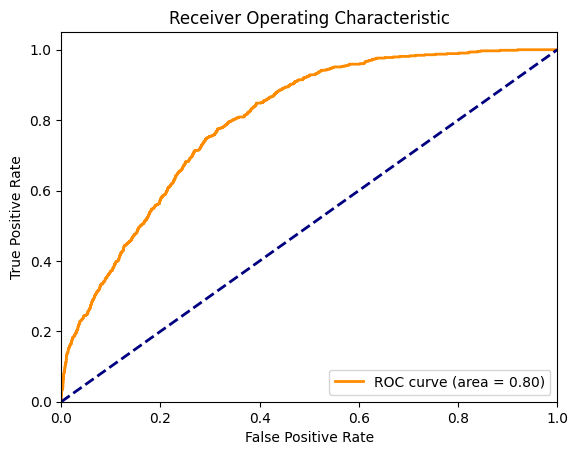

In [171]:
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_pred_proba)

print(f"Accuracy: {accuracy}")
print(f"Confusion Matrix:\n{conf_matrix}")
print(f"Classification Report:\n{class_report}")
print(f"F1 Score: {f1}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"AUC: {auc}")

# Plot ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


              precision    recall  f1-score   support

           0       0.95      0.95      0.95      7015
           1       0.43      0.42      0.42       648

    accuracy                           0.90      7663
   macro avg       0.69      0.68      0.68      7663
weighted avg       0.90      0.90      0.90      7663

Accuracy: 0.9030405846274305
Confusion Matrix:
[[6650  365]
 [ 378  270]]
Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.95      0.95      7015
           1       0.43      0.42      0.42       648

    accuracy                           0.90      7663
   macro avg       0.69      0.68      0.68      7663
weighted avg       0.90      0.90      0.90      7663

F1 Score: 0.4208885424785659
Precision: 0.4251968503937008
Recall: 0.4166666666666667
AUC: 0.8569099064614626


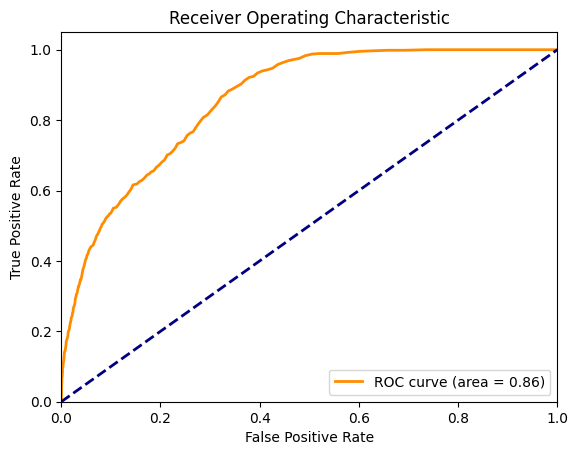

In [16]:
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Resample the training data
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

# Define the model and parameter grid
model = RandomForestClassifier(random_state=42)
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10]
}

# Perform grid search
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, scoring='f1', cv=5)
grid_search.fit(X_resampled, y_resampled)
best_model = grid_search.best_estimator_

# Evaluate the model
y_pred = best_model.predict(X_test)
y_pred_proba = best_model.predict_proba(X_test)[:, 1]
print(classification_report(y_test, y_pred))

accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_pred_proba)

print(f"Accuracy: {accuracy}")
print(f"Confusion Matrix:\n{conf_matrix}")
print(f"Classification Report:\n{class_report}")
print(f"F1 Score: {f1}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"AUC: {auc}")

# Plot ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


In [17]:
import joblib 

joblib.dump(best_model, 'model_01.joblib', compress = 3)

['model_01.joblib']

In [192]:
X_resampled

,Trainings_Attended,Last_performance_score,Targets_met,Previous_Award,Training_score_average,Division_encoded,Qualification_encoded,Gender_encoded,Channel_of_Recruitment_encoded,State_Of_Origin_encoded,Foreign_schooled_encoded,Marital_Status_encoded,Past_Disciplinary_Action_encoded,Previous_IntraDepartmental_Movement_encoded,No_of_previous_employers_encoded,age,no_of_years_in_the_company
0,2,10.000000,0,0,45,5,1,1,0,30,1,2,0,0,1,46,18
1,2,7.500000,0,0,46,5,0,0,0,22,1,0,0,0,1,30,7
2,2,0.000000,0,0,39,5,2,1,1,8,1,0,0,0,0,18,1
3,3,2.500000,0,0,52,2,0,1,1,16,1,0,0,0,1,30,3
4,2,7.500000,0,0,44,1,1,0,1,27,1,2,0,0,1,34,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56107,2,9.373617,1,0,40,1,0,1,0,7,1,0,0,0,0,31,3
56108,2,7.500000,0,1,84,3,0,1,1,27,1,0,0,0,0,32,3
56109,2,9.829877,0,0,82,2,1,0,0,14,1,0,0,0,1,54,16
56110,2,7.500000,0,0,76,7,0,0,0,23,0,0,0,0,1,32,4


In [195]:
X_resampled.columns

Index(['Trainings_Attended', 'Last_performance_score', 'Targets_met',
       'Previous_Award', 'Training_score_average', 'Division_encoded',
       'Qualification_encoded', 'Gender_encoded',
       'Channel_of_Recruitment_encoded', 'State_Of_Origin_encoded',
       'Foreign_schooled_encoded', 'Marital_Status_encoded',
       'Past_Disciplinary_Action_encoded',
       'Previous_IntraDepartmental_Movement_encoded',
       'No_of_previous_employers_encoded', 'age',
       'no_of_years_in_the_company'],
      dtype='object')

In [194]:
X_resampled['Gender_encoded']

0        1
1        0
2        1
3        1
4        0
        ..
56107    1
56108    1
56109    0
56110    0
56111    0
Name: Gender_encoded, Length: 56112, dtype: int64

In [189]:
X_train[['State_Of_Origin_encoded', 'Foreign_schooled_encoded']]

,State_Of_Origin_encoded,Foreign_schooled_encoded
10755,30,1
4933,22,1
8028,8,1
1953,16,1
32336,27,1
...,...,...
23514,0,1
36605,32,1
30611,24,1
25957,27,1


Best parameters found:  {'C': 0.1, 'penalty': 'l1', 'solver': 'liblinear'}
Best F1 score:  0.7625225027914247
Best parameters found:  {'C': 0.1, 'penalty': 'l1', 'solver': 'liblinear'}
Accuracy: 0.9196137283048414
Confusion Matrix:
[[6996   19]
 [ 597   51]]
Classification Report:
              precision    recall  f1-score   support

           0       0.92      1.00      0.96      7015
           1       0.73      0.08      0.14       648

    accuracy                           0.92      7663
   macro avg       0.82      0.54      0.55      7663
weighted avg       0.91      0.92      0.89      7663

F1 Score: 0.14206128133704735
Precision: 0.7285714285714285
Recall: 0.0787037037037037
AUC: 0.8044732187640242


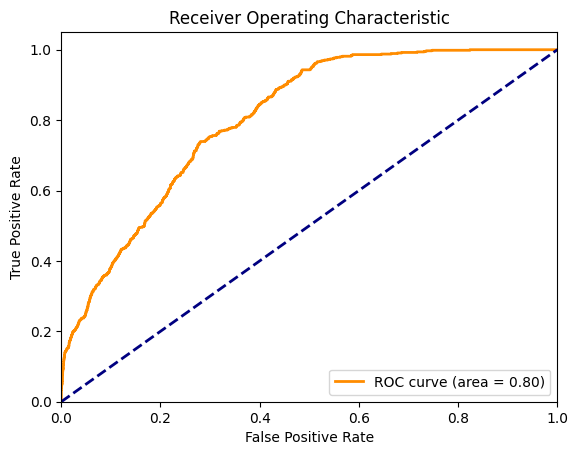

In [182]:
from sklearn.model_selection import GridSearchCV

# Define parameter grid
param_grid = {
    'C': [0.1, 1, 10, 100],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear']
}

# Create logistic regression model
model = LogisticRegression()

# Create GridSearchCV object
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='f1')

# Fit the model
grid_search.fit(X_resampled, y_resampled)

# Best parameters
print("Best parameters found: ", grid_search.best_params_)

# Best score
print("Best F1 score: ", grid_search.best_score_)


best_params = grid_search.best_params_
print("Best parameters found: ", best_params)

# Train the final model with the best parameters
final_model = LogisticRegression(**best_params)
final_model.fit(X_train, y_train)

# Make predictions with the final model
y_pred = final_model.predict(X_test)
y_pred_proba = final_model.predict_proba(X_test)[:, 1]

# Evaluate the final model
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_pred_proba)

print(f"Accuracy: {accuracy}")
print(f"Confusion Matrix:\n{conf_matrix}")
print(f"Classification Report:\n{class_report}")
print(f"F1 Score: {f1}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"AUC: {auc}")

# Plot ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

              precision    recall  f1-score   support

           0       1.00      0.70      0.82      7015
           1       0.23      0.97      0.37       648

    accuracy                           0.72      7663
   macro avg       0.61      0.83      0.60      7663
weighted avg       0.93      0.72      0.78      7663

Accuracy: 0.7211274957588412
Confusion Matrix:
[[4900 2115]
 [  22  626]]
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.70      0.82      7015
           1       0.23      0.97      0.37       648

    accuracy                           0.72      7663
   macro avg       0.61      0.83      0.60      7663
weighted avg       0.93      0.72      0.78      7663

F1 Score: 0.36943051047506636
Precision: 0.2283838015322875
Recall: 0.9660493827160493
AUC: 0.5180294870779547


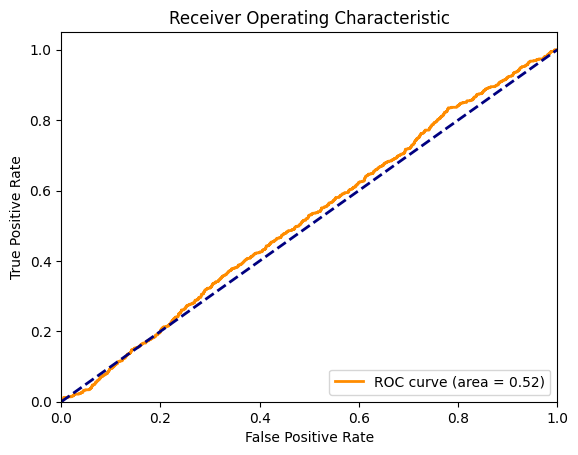

In [174]:
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Resample the training data
from imblearn.under_sampling import RandomUnderSampler
rus = RandomUnderSampler(random_state=42)
X_resampled, y_resampled = rus.fit_resample(X, y)

# Define the model and parameter grid
model = RandomForestClassifier(random_state=42)
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10]
}

# Perform grid search
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, scoring='f1', cv=5)
grid_search.fit(X_resampled, y_resampled)
best_model = grid_search.best_estimator_

# Evaluate the model
y_pred = best_model.predict(X_test)
print(classification_report(y_test, y_pred))

accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_pred_proba)

print(f"Accuracy: {accuracy}")
print(f"Confusion Matrix:\n{conf_matrix}")
print(f"Classification Report:\n{class_report}")
print(f"F1 Score: {f1}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"AUC: {auc}")

# Plot ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


Fitting 5 folds for each of 72 candidates, totalling 360 fits
              precision    recall  f1-score   support

           0       0.97      0.83      0.89      7015
           1       0.26      0.68      0.38       648

    accuracy                           0.81      7663
   macro avg       0.61      0.75      0.64      7663
weighted avg       0.91      0.81      0.85      7663

Fitting 5 folds for each of 72 candidates, totalling 360 fits
              precision    recall  f1-score   support

           0       0.97      0.83      0.89      7015
           1       0.26      0.68      0.38       648

    accuracy                           0.81      7663
   macro avg       0.61      0.75      0.64      7663
weighted avg       0.91      0.81      0.85      7663

Accuracy: 0.8128670233589977
Confusion Matrix:
[[5789 1226]
 [ 208  440]]
Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.83      0.89      7015
           1    

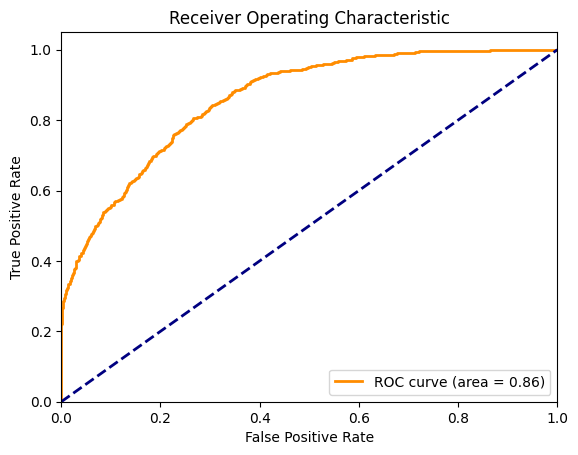

In [183]:
import xgboost as xgb
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report


# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Apply SMOTE to the training data
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)


# Define the XGBoost model
model = xgb.XGBClassifier(objective='binary:logistic', scale_pos_weight=len(y_train[y_train == 0]) / len(y_train[y_train == 1]))

# Define the parameter grid
param_grid = {
    'n_estimators': [100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}


# Perform grid search
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, scoring='f1', cv=5, n_jobs=-1, verbose=2)
grid_search.fit(X_resampled, y_resampled)

# Get the best model
best_model = grid_search.best_estimator_

# Predict on the test set
y_pred = best_model.predict(X_test)

# Print classification report
print(classification_report(y_test, y_pred))


import xgboost as xgb
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Apply SMOTE to the training data
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

# Define the XGBoost model
model = xgb.XGBClassifier(objective='binary:logistic', scale_pos_weight=len(y_train[y_train == 0]) / len(y_train[y_train == 1]))

# Define the parameter grid
param_grid = {
    'n_estimators': [100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

# Perform grid search
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, scoring='f1', cv=5, n_jobs=-1, verbose=2)
grid_search.fit(X_resampled, y_resampled)

# Get the best model
best_model = grid_search.best_estimator_

# Predict on the test set
y_pred = best_model.predict(X_test)
y_pred_proba = best_model.predict_proba(X_test)[:, 1]
# Print classification report
print(classification_report(y_test, y_pred))


accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_pred_proba)

print(f"Accuracy: {accuracy}")
print(f"Confusion Matrix:\n{conf_matrix}")
print(f"Classification Report:\n{class_report}")
print(f"F1 Score: {f1}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"AUC: {auc}")

# Plot ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


Fitting 5 folds for each of 324 candidates, totalling 1620 fits
[LightGBM] [Info] Number of positive: 28056, number of negative: 28056
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004626 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 485
[LightGBM] [Info] Number of data points in the train set: 56112, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
              precision    recall  f1-score   support

           0       0.96      0.85      0.91      7015
           1       0.29      0.64      0.40       648

    accuracy                           0.84      7663
   macro avg       0.63      0.75      0.65      7663
weighted avg       0.91      0.84      0.86      7663

Accuracy: 0.8363565183348558
Confusion Matrix:
[[5993 1022]
 [ 232  416]]
Classification Report:
          

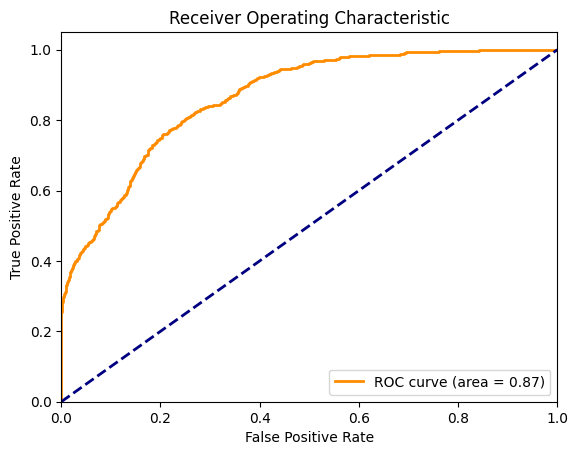

In [184]:
import lightgbm as lgb
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Apply SMOTE to the training data
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

# Define the LightGBM model
model = lgb.LGBMClassifier(objective='binary', scale_pos_weight=len(y_train[y_train == 0]) / len(y_train[y_train == 1]), random_state=42)

# Define the parameter grid
param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2],
    'num_leaves': [31, 41, 51],
    'max_depth': [-1, 10, 20],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

# Perform grid search
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, scoring='f1', cv=5, n_jobs=-1, verbose=2)
grid_search.fit(X_resampled, y_resampled)

# Get the best model
best_model = grid_search.best_estimator_

# Predict on the test set
y_pred = best_model.predict(X_test)
y_pred_proba = best_model.predict_proba(X_test)[:, 1]
# Print classification report
print(classification_report(y_test, y_pred))

accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_pred_proba)

print(f"Accuracy: {accuracy}")
print(f"Confusion Matrix:\n{conf_matrix}")
print(f"Classification Report:\n{class_report}")
print(f"F1 Score: {f1}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"AUC: {auc}")

# Plot ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()
